In [1]:
import pandas as pd
import numpy as np

import joblib
import sklearn

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
dataset = pd.read_csv("Test_data_10k.csv")

In [3]:
dataset.drop(labels=['index'], axis=1, inplace=True)

In [4]:
dataset[" Label"].value_counts()

1    5000
0    5000
Name:  Label, dtype: int64

In [5]:
dataset.columns

Index([' Source Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Flow IAT Mean', ' Flow IAT Std',
       ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean',
       ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total',
       ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count',
       ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count',

In [6]:
#splitting the data into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop(labels=[' Label'], axis=1),
    dataset[' Label'],
    test_size=0.3,
    random_state=None)

X_train.shape, X_test.shape

((7000, 67), (3000, 67))

In [7]:
# Standardization is only performed on numerical columns and not on One hot encoded features
# as it would mean assigning a distribution to categorical features

numeric_columns = [' Source Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Flow IAT Mean', ' Flow IAT Std',
       ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean',
       ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total',
       ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count',
       ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' ECE Flag Count', ' Down/Up Ratio',
       ' Average Packet Size', ' Avg Fwd Segment Size',
       ' Avg Bwd Segment Size', ' Fwd Header Length.1', 'Subflow Fwd Packets',
       ' Subflow Fwd Bytes', ' Subflow Bwd Packets', ' Subflow Bwd Bytes',
       'Init_Win_bytes_forward', ' Init_Win_bytes_backward',
       ' act_data_pkt_fwd', ' min_seg_size_forward', 'Active Mean',
       ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
       ' Idle Max', ' Idle Min']

In [8]:
#Performing standardization 

for i in numeric_columns:
    scale_var = StandardScaler().fit(X_train[[i]])
    X_train[i] = scale_var.transform(X_train[[i]])
    X_test[i] = scale_var.transform(X_test[[i]])

In [9]:
scale_var

StandardScaler()

<AxesSubplot: >

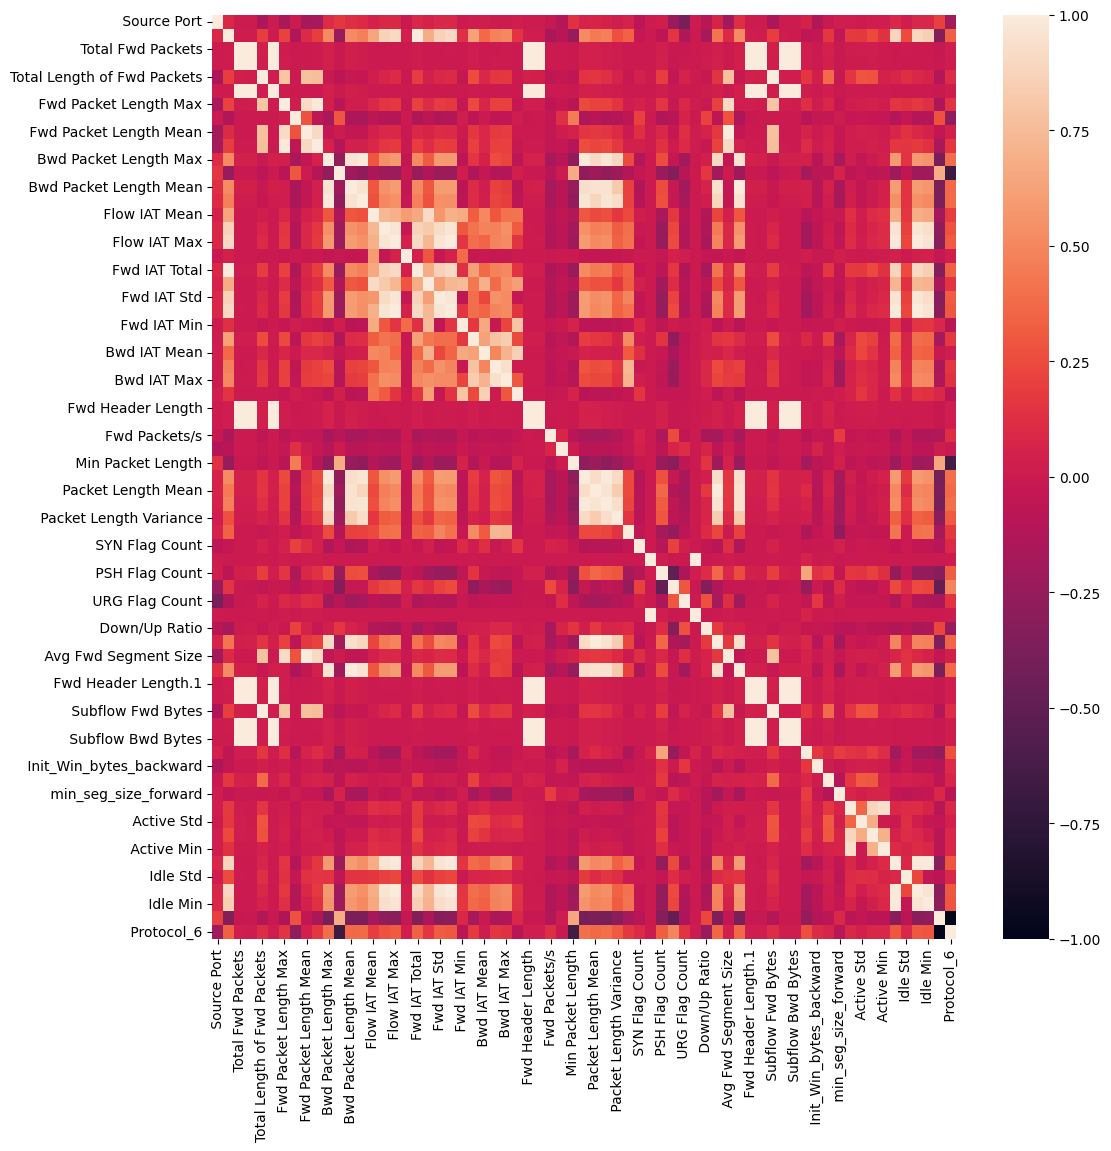

In [10]:
#Visualizing correlated features

cor_mat = X_train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(12,12)
sns.heatmap(cor_mat)

In [11]:
#A function to select highly correlated features 

def Correlation(data, threshold):
    col_cor = set()   #set of all names of correlated columns
    cor_matrix = dataset.corr()
    for i in range(len(cor_matrix.columns)):
        for j in range(i):
            if abs(cor_matrix.iloc[i, j]) > threshold: #Absolute coeff value is used
                colName = cor_matrix.columns[i]  #saving the names of correlated columns
                col_cor.add(colName)
    return col_cor
            

In [12]:
cor_features = Correlation(X_train, 0.9)
len(set(cor_features))

30

In [13]:
cor_features

{' Active Min',
 ' Average Packet Size',
 ' Avg Bwd Segment Size',
 ' Avg Fwd Segment Size',
 ' Bwd Header Length',
 ' Bwd IAT Max',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 ' ECE Flag Count',
 ' Flow IAT Max',
 ' Fwd Header Length',
 ' Fwd Header Length.1',
 ' Fwd IAT Max',
 ' Fwd IAT Std',
 ' Fwd Packet Length Std',
 ' Idle Max',
 ' Idle Min',
 ' Max Packet Length',
 ' Packet Length Mean',
 ' Packet Length Std',
 ' Packet Length Variance',
 ' Protocol_6',
 ' Subflow Bwd Bytes',
 ' Subflow Bwd Packets',
 ' Subflow Fwd Bytes',
 ' Total Backward Packets',
 ' Total Length of Bwd Packets',
 'Fwd IAT Total',
 'Idle Mean',
 'Subflow Fwd Packets'}

In [14]:
#Dropping the highly correlated features

X_train.drop(labels=cor_features, axis=1, inplace=True)
X_test.drop(labels=cor_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((7000, 37), (3000, 37))

In [2]:
hyperparameters = [{'kernel':['rbf'], 'C':[0.1,1,10,100], 
                    'gamma':[1,0.1,0.01,0.001]}]

In [16]:
model = SVC(random_state=1)

In [17]:
FinalModel = RandomizedSearchCV(
             model,
             param_distributions = hyperparameters,
             cv = 10,
             n_jobs = -1)


In [18]:
FinalModel.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=SVC(random_state=1), n_jobs=-1,
                   param_distributions=[{'C': [0.1, 1, 10, 100],
                                         'gamma': [1, 0.1, 0.01, 0.001],
                                         'kernel': ['rbf']}])

In [19]:
print("Accuracy score on Validation set: \n")
print(FinalModel.best_score_ )
print("---------------")
print("Best performing hyperparameters on Validation set: ")
print(FinalModel.best_params_)
print("---------------")
print(FinalModel.best_estimator_)

Accuracy score on Validation set: 

0.9821428571428571
---------------
Best performing hyperparameters on Validation set: 
{'kernel': 'rbf', 'gamma': 1, 'C': 100}
---------------
SVC(C=100, gamma=1, random_state=1)


In [20]:
Validated_Model = FinalModel.best_estimator_

In [21]:
Validated_Model

SVC(C=100, gamma=1, random_state=1)

In [22]:
predictions = Validated_Model.predict(X_test)

In [23]:
predictions

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [24]:
print(accuracy_score(y_test, predictions))

0.988


In [25]:
con_mat = confusion_matrix(y_test, predictions)
print(con_mat)

[[1482   12]
 [  24 1482]]


<AxesSubplot: >

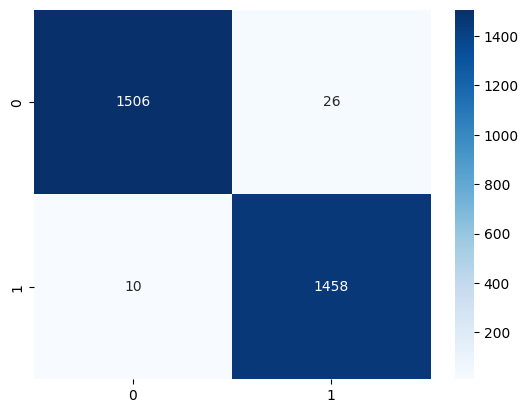

In [26]:
cmat = np.array([[1482,   12],[24,   1482]])

sns.heatmap(cmat, annot=True,fmt="d",cmap='Blues')

In [27]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9841    0.9920    0.9880      1494
           1     0.9920    0.9841    0.9880      1506

    accuracy                         0.9880      3000
   macro avg     0.9880    0.9880    0.9880      3000
weighted avg     0.9880    0.9880    0.9880      3000

